In [11]:
import math
import json
import pickle
import random
import logging
import glob
import argparse
import os
import warnings
import pandas as pd
import numpy as np
from gensim import models
from gensim import matutils
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.cluster import KMeans, Birch, SpectralClustering, DBSCAN, AgglomerativeClustering
from sklearn.manifold import MDS
from sklearn.decomposition import PCA
from scipy.spatial.distance import cdist
from time import time
from nltk.tokenize import sent_tokenize
from pathlib2 import Path
from nltk.corpus import stopwords
from collections import Counter, OrderedDict
STOP_WORDS = stopwords.words('english')
from matplotlib import cm
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
cluster_colors = {-1:'black', 0:'gold', 1:'blue', 2:'green', 3:'red', 4:'saddlebrown', 5:'darkviolet', 
            6:'yellow', 7:'pink', 8:'orange', 9:'firebrick', 10:'deepskyblue',
            11:'aqua', 12:'saddlebrown', 13:'springgreen', 14:'dodgerblue', 15:'coral',
            16:'mediumslateblue', 17:'magenta', 18:'seagreen', 19:'lightslategrey', 20:'cyan'}
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [12]:
%%time
import os
from pathlib import Path
from collections import Counter, OrderedDict

N = 50
allfiles = os.listdir("C:\\Projects\\CapstoneCS598\\Task2\\Categories")

review_counter = {}

for f in allfiles:
    cuisine = f
    with open(Path("C:\\Projects\\CapstoneCS598\\Task2\\Categories", f), 'r', encoding='utf-8') as file:
        count = len(file.readlines())
    review_counter.update({cuisine: count})

review_counter = Counter(review_counter)
topN_cuisines = list(OrderedDict(review_counter.most_common(N)).keys())


CPU times: total: 125 ms
Wall time: 391 ms


In [13]:
%%time
import os
from pathlib import Path

# Define the directory containing the text files
directory = "C:\\Projects\\CapstoneCS598\\Task2\\Categories"

# Get the list of all files in the directory
allfiles = os.listdir(directory)

# Process each file in the list
cuisines = [f.replace('.txt', '') for f in allfiles]
contents = []
for f in allfiles:
    # Construct the full path to the file
    file_path = os.path.join(directory, f)
    # Read the contents of the file
    content = Path(file_path).read_text(encoding="utf8").replace('\n', ' ')
    contents.append(content)


CPU times: total: 422 ms
Wall time: 539 ms


In [14]:
def vectorizer(contents, use_idf=False, min_df=2, max_df=0.5, stop_words=None):
    vectorizer = TfidfVectorizer(stop_words=stop_words,
                                 encoding='utf-8',
                                 strip_accents='unicode',
                                 lowercase=True,
                                 use_idf=use_idf,
                                 max_features=10000,
                                 min_df=min_df,
                                 max_df=max_df)
    matrix = vectorizer.fit_transform(contents)
    
    id2words = {i: word for i, word in enumerate(vectorizer.get_feature_names_out())}
    
    return matrix, np.vstack([cosine_similarity(val, matrix) for val in matrix]), id2words


In [15]:
def draw(matrix, colormap='BuPu'):
    # https://matplotlib.org/tutorials/colors/colormaps.html
    fig, ax = plt.subplots()
    cax = ax.matshow(matrix, cmap=colormap)
    ax.set_xticks(np.arange(matrix.shape[1]), minor=False)
    ax.set_yticks(np.arange(matrix.shape[0]), minor=False)
    ax.grid(which='major', color='blue', linestyle='-', linewidth='0.3')
    ax.set_xticklabels(matrix.index, rotation='vertical')
    ax.set_yticklabels(matrix.index)
    fig.colorbar(cax, ticks=np.linspace(0,1,11))
    fig.set_size_inches(20, 20)
    plt.show()

In [16]:
%%time
matrix_if1, similarity_if1, id2words1 = vectorizer(contents, use_idf=False)

CPU times: total: 14.6 s
Wall time: 17 s


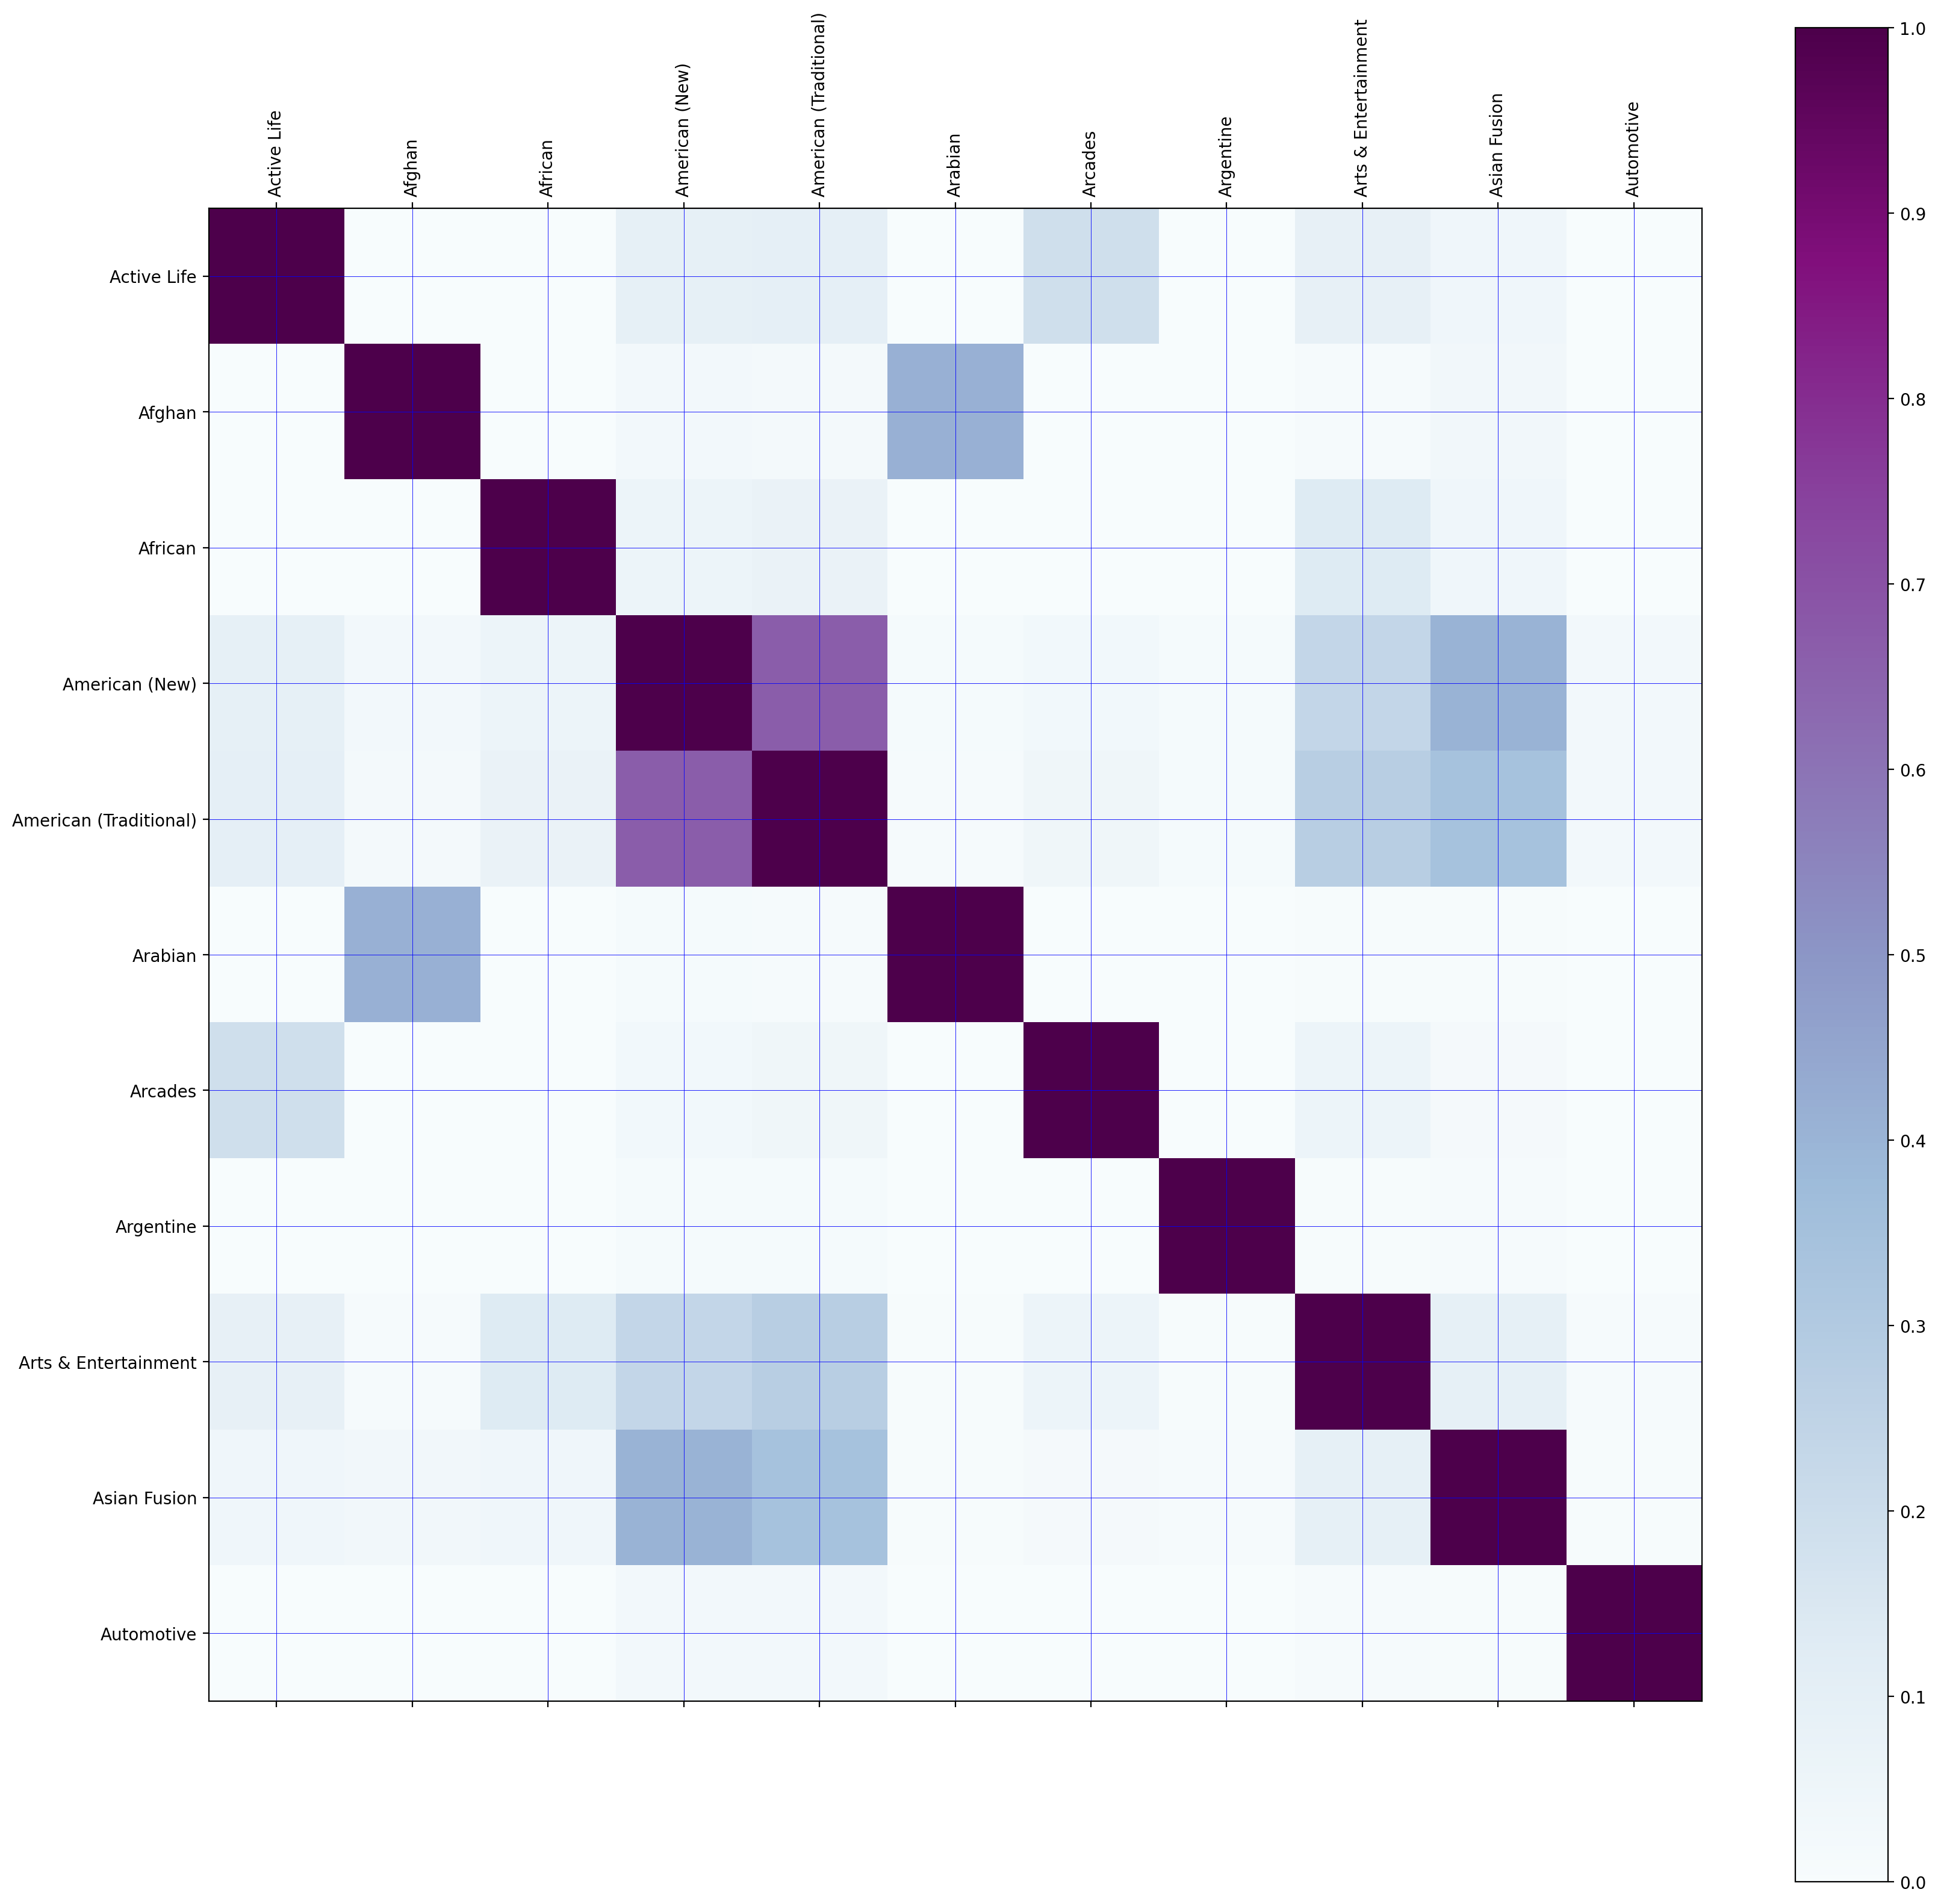

In [17]:
matrix = pd.DataFrame(similarity_if1)
matrix.columns = cuisines
matrix.index = cuisines
draw(matrix)

In [ ]:
%%time
vectorizer = TfidfVectorizer(stop_words=STOP_WORDS,
                             encoding='utf-8',
                             strip_accents='unicode',
                             lowercase=True,
                             use_idf=True,
                             max_features=10000,
                             min_df=0.2, max_df=0.7)
matrix = vectorizer.fit_transform(contents)

In [ ]:
# %%time
# id2words ={}
# for i,word in enumerate(vectorizer.get_feature_names()):
#     id2words[i] = word
# # include LDA
# corpus = matutils.Sparse2Corpus(matrix, documents_columns=False)
# lda = models.ldamodel.LdaModel(corpus, 
#                                 num_topics=50,
#                                 id2word=id2words,
#                                 alpha='auto',
#                                 eval_every=5) # can play around with number of topics
# doc_topics = lda.get_document_topics(corpus)

# topic_pro = np.zeros((len(cuisines), len(doc_topics)))
# idx = 0
# for val in doc_topics:
#     for jdx, pro in val:
#         topic_pro[idx][jdx] = pro
#     idx += 1

import numpy as np
from gensim import matutils, models
from scipy.sparse import csr_matrix
import pandas as pd
import time

# Assuming you have already defined cuisines and vectorizer
# Assuming df is your DataFrame containing the data

start_time = time.time()

# Assuming df is your DataFrame containing the data
matrix = csr_matrix(df.values)

id2words = {}
feature_names = vectorizer.get_feature_names_out()
for i, word in enumerate(feature_names):
    id2words[i] = word

# Include LDA
corpus = matutils.Sparse2Corpus(matrix, documents_columns=False)
lda = models.ldamodel.LdaModel(corpus, 
                                num_topics=50,
                                id2word=id2words,
                                alpha='auto',
                                eval_every=5)  # You can adjust parameters here
doc_topics = lda.get_document_topics(corpus)

topic_pro = np.zeros((len(cuisines), len(doc_topics)))
idx = 0
for val in doc_topics:
    for jdx, pro in val:
        topic_pro[idx][jdx] = pro
    idx += 1

end_time = time.time()
execution_time = end_time - start_time
print("Execution time:", execution_time, "seconds")


In [ ]:
%matplotlib inline
matrix = pd.DataFrame(np.vstack([cosine_similarity(val.reshape(1, -1), topic_pro) for val in topic_pro]))
matrix.columns = cuisines
matrix.index = cuisines
draw(matrix)

In [33]:
%%time
matrix_if2, similarity_if2, id2words2 = vectorizer(contents, use_idf=True, min_df=2, max_df=0.5)

TypeError: 'TfidfVectorizer' object is not callable